### Assignment to plot the composite of a variable of intererst (zonal wind stress) based on an index (RMM)

#### RMM index is downloaded from:
    
http://www.bom.gov.au/climate/mjo/graphics/rmm.74toRealtime.txt

#### RMM stands for Real-time Multivariate MJO Index. Wheeler and Hendon (2004) constructed the RMM index for monitoring the MJO. This index consists of the first two principal components (PCs) of OLR, 850-hPa zonal wind, and 200-hPa zonal wind averaged 15S-15N.

#### The time series data is divided into eight phases based on the RMM values and each day is assigned to a phase between 1 and 8. Then, the composite average of all the days assocaited with each phase is calculated and plotted as shown below.

##### References: 

##### Wheeler and Hendon (2004), An All-Season Real-Time Multivariate MJO Index: Development of an Index for Monitoring and Prediction

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature

import calendar

#### Load daily zonal winds stress and calculate anomalies

In [2]:
file='/home/rmantrip/CLIM680/clim680_dataset/tropflux/taux_tropflux_1979.2017.nc'
ds=xr.open_dataset(file)
taux = ds.taux.sel(time=slice('1980','2016')).astype('float32')

tauxc = taux.groupby('time.dayofyear').mean() # Calculation of daily climatology
tauxa = taux.groupby('time.dayofyear') - tauxc # Calculation of daily anomalies

del taux,tauxc # deleted the variables to free the memory. Not necessary but initially thought of plotting the RMM phases for SST as well.
               # SST occupies more memory and program freezes when executing the code.  

#### Load RMM index 

In [3]:
path = '/home/rmantrip/CLIM680/clim680_dataset/'
file='rmm.74toRealtime.txt'
index_name='phase'

df=pd.read_table(path+file,skiprows=2,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=False,
                 na_values=['-99.9','-99.90'])
df = df.query('1980 <= index <= 2016')
phase = df.iloc[:,4].values

#### Approximate locations of the MJO centre of convection RMM Index phases 1-8

![MJO Phase Locations](MJOPhaseLocations.png)

### Calculate the average of zonal wind stress anomlaies across RMM phases 
#### The data covers the period between 1980 and 2016.

#### Instead of adding a RMM phase dimension to the zonal wind stress anomalies, I replaced the time values with RMM phase values (1-8). Thus, I can use groupby function to average across the RMM phases.

In [4]:
tauxa['time'] = phase
tauxphase = tauxa.groupby('time').mean()

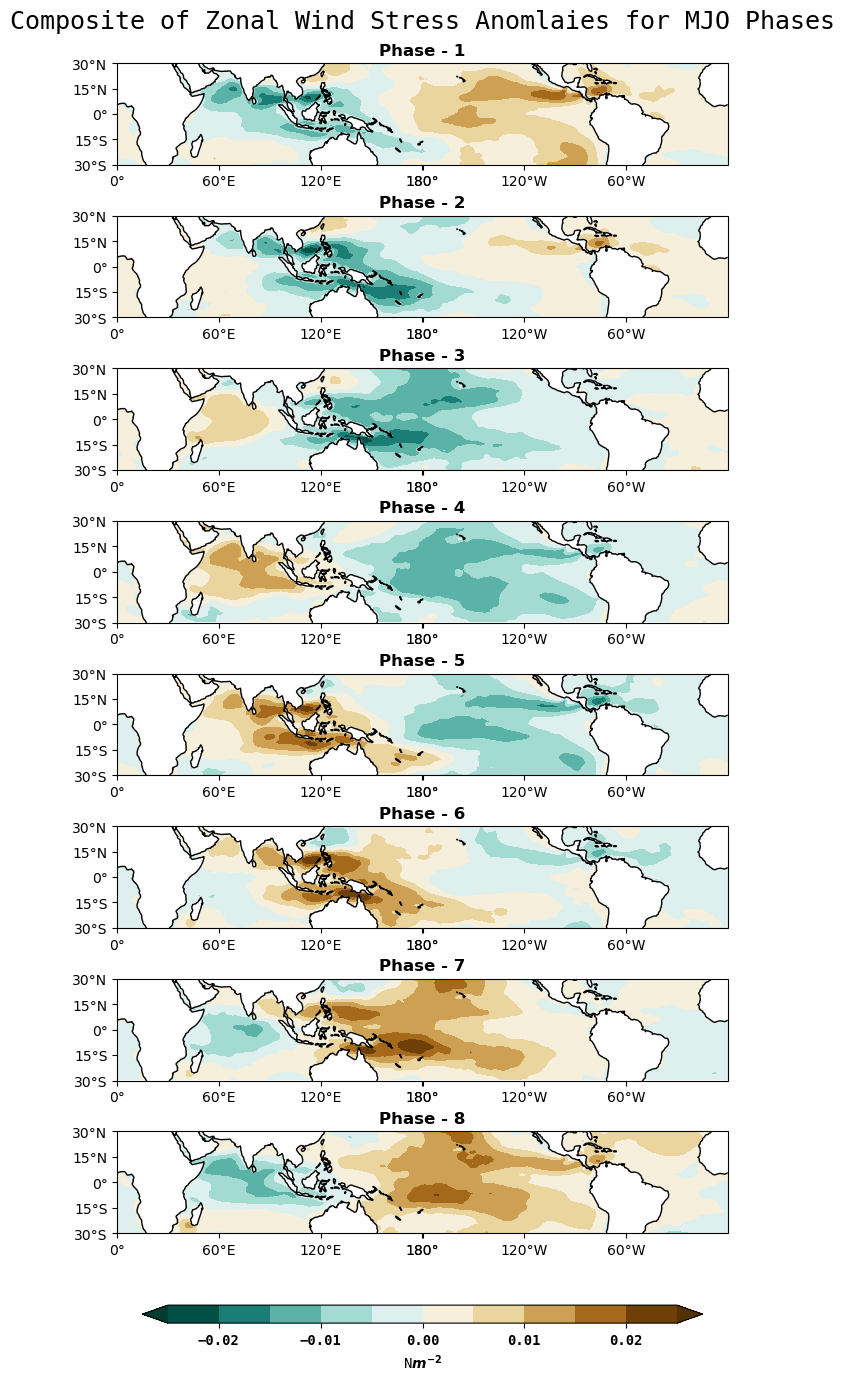

In [5]:
# Define the figure and each axis for the 2 rows and 2 columns
fig, axs = plt.subplots(nrows=8,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
                        figsize=(14,18))

plt.rc({'titleweight':'bold'})

font = {'family' : 'monospace',
        'weight' : 'bold'}

plt.rc('font', **font)  

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

clevs=np.arange(-0.025,0.03,0.005)

#Loop over all of the months and plot
for i,seas in enumerate(tauxphase['time']):
        # Select the month
        data=tauxphase.sel(time=seas.values)

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=tauxphase['longitude'])

        # Contour plot
        cs=axs[i].contourf(lons,tauxphase['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG_r',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(-30,31,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Title each subplot with the name of the month
        axs[i].set_title('Phase - '+str(seas.values),fontweight='bold')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.3, 0.2, 0.4, 0.01])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='N$m^{-2}$')

# Add a big title at the top
plt.suptitle('Composite of Zonal Wind Stress Anomlaies for MJO Phases',fontsize=18,y=0.93);

#### Interpretation:

#### The positive (brown shading) and negative (green shading) anomalies indicate westerly and easterly zonal wind stress anomlaies, respectively. 

#### The westerly zonal wind anomalies associated with the convection (clouds) initiate over the Indian ocean in phase 2 and moves eastward towards the maritime continent (phases 4-5) and central Pacific (7-8). The MJO associated convective signals weakens and decouple with the winds (not shown). The anomlaous winds associated with the MJO moves faster in the eastern Pacifc than in Indian ocean. 
